# First Quantization

SELECT and PREPARE for the first quantized chemistry Hamiltonian.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran.drawing import show_bloq
from typing import *
import numpy as np

## `PrepareKineticFirstQuantization`
PREPARE for the kinetic energy operator for the first quantized chemistry Hamiltonian.

This prepares the state

$$
    |+\rangle\sum_{j=1}^{\eta}|j\rangle\sum_{w=0}^{2}|w\rangle\sum_{r=0}^{n_{p}-2}2^{r/2}|r\rangle
    \sum_{s=0}^{n_{p}-2}2^{s/2}|s\rangle
$$

#### Parameters
 - `num_pw_each_dim`: The number of planewaves in each of the x, y and z directions. In total, for a cubic box, there are N = num_pw_each_dim**3 planewaves. The number of bits required (in each dimension) is thus $log N^1/3 + 1$, where the + 1 is for the sign bit.
 - `eta`: The number of electrons.
 - `num_bits_rot_aa`: The number of bits of precision for the single qubit rotation for amplitude amplification. Called $b_r$ in the reference. 

Registers:

#### References
[Fault-Tolerant Quantum Simulations of Chemistry in First Quantization] (https://arxiv.org/abs/2105.12767) page 19, section B


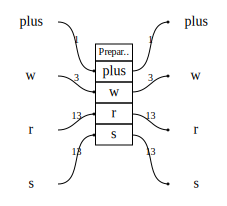

In [2]:
from qualtran.bloqs.chemistry.first_quantization import PrepareKineticFirstQuantization

num_pw = (2 * 10 + 1) ** 3
eta = 10
bloq = PrepareKineticFirstQuantization(num_pw, eta)
show_bloq(bloq)